# analysis of 10x Visium data
In this practical, we will get to know the Python ecosystem for (spatial) data. We will work on a mouse brain data set from [Kleshchevnikov et al., 2022](https://doi.org/10.1038/s41587-021-01139-4). The data can be downloaded [here](https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_visium_wo_cloupe_data.zip) (we will use only the ST8059048 sample).

Since some calculations take a lot of time or memory, we also provide precomputed results that we will use in this notebook. You can download a bundle of all required data and results [here](https://hub.dkfz.de/s/HEaCoDNqozPwJ8p).

## libraries and first impressions
Let's start by loading the required packages. [NumPy](https://www.numpy.org), [SciPy](https://www.scipy.org), [Matplotlib](https://matplotlib.org/) (and arguably [seaborn](https://seaborn.pydata.org/)) are the pillars of the scientific Python stack and belong on every scientist's computer. [AnnData](https://anndata.readthedocs.io) provides a container object that can hold the raw data, associated metadata, and transformed/analyzed data, such as pairwise distance matrices or embeddings. [Muon](https://gtca.github.io/muon/) builds on top of AnnData to provide a container for multimodal data. [Scanpy](https://scanpy.readthedocs.io) is the Python equivalent to Seurat. It works on AnnData objects and provides many preprocessing, analysis, and visualization methods. [Squidpy](https://squidpy.readthedocs.io) is a new package geared towards spatial data. It also works on AnnData objects and is focused on analysis of graphs and images. It also provides interactive visualization using [Napari](https://napari.org). [SpatialDE](https://github.com/ilia-kats/SpatialDE) accepts AnnData objects as well and can detect spatially variable genes as well as perform segmentation of tissue regions taking both gene expression and spatial coordinates into account. [Cell2location](https://github.com/BayraktarLab/cell2location), built on top of [scvi-tools](https://scvi-tools.org/) and [Pyro](http://pyro.ai/), also works with AnnData objects and can deconvolve array data using a single-cell reference with annotated cell types.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import muon as mu
import squidpy as sq
import scanpy as sc
import cell2location
from cell2location.utils.filtering import filter_genes
from cell2location.plt import plot_spatial
from cell2location.models import RegressionModel, Cell2location
import scvi
import mofapy2
import mofax

plt.rcParams["figure.figsize"] = (8, 8)

import SpatialDE

Global seed set to 0
2022-04-28 10:04:09.024786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/cudnn/7.6.1.34/cuda10.1/lib64:/software/python/3.7.0/lib:/software/python/3.7.0/lib64:/software/openssl/1.1.0h/lib
2022-04-28 10:04:09.025642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/cudnn/7.6.1.34/cuda10.1/lib64:/software/python/3.7.0/lib:/software/python/3.7.0/lib64:/software/openssl/1.1.0h/lib
2022-04-28 10:04:09.025669: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

Scanpy provides a handy function to read Visium data as it comes out of the 10x pipeline.

In [2]:
adata = sc.read_visium("data/ST8059048")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


You can think of AnnData as a spots x genes matrix (spots are called `obs` and genes are called `vars` in AnnData) together with some metadata.

In [3]:
adata

AnnData object with n_obs × n_vars = 2987 × 31053
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Each observation and each gene can have associated metadata, which are stored in Pandas dataframes.

In [4]:
adata.obs

in_tissue  array_row  array_col
AAACAAGTATCTCCCA-1          1         50        102
AAACACCAATAACTGC-1          1         59         19
AAACAGAGCGACTCCT-1          1         14         94
AAACAGCTTTCAGAAG-1          1         43          9
AAACAGGGTCTATATT-1          1         47         13
...                       ...        ...        ...
TTGTTCAGTGTGCTAC-1          1         24         64
TTGTTGTGTGTCAAGA-1          1         31         77
TTGTTTCACATCCAGG-1          1         58         42
TTGTTTCATTAGTCTA-1          1         60         30
TTGTTTCCATACAACT-1          1         45         27

[2987 rows x 3 columns]

In [5]:
adata.var

gene_ids    feature_types              genome
Xkr4            ENSMUSG00000051951  Gene Expression  mm10-3.0.0_premrna
Gm1992          ENSMUSG00000089699  Gene Expression  mm10-3.0.0_premrna
Gm37381         ENSMUSG00000102343  Gene Expression  mm10-3.0.0_premrna
Rp1             ENSMUSG00000025900  Gene Expression  mm10-3.0.0_premrna
Sox17           ENSMUSG00000025902  Gene Expression  mm10-3.0.0_premrna
...                            ...              ...                 ...
AC168977.1      ENSMUSG00000079808  Gene Expression  mm10-3.0.0_premrna
AC149090.1      ENSMUSG00000095041  Gene Expression  mm10-3.0.0_premrna
CAAA01118383.1  ENSMUSG00000063897  Gene Expression  mm10-3.0.0_premrna
Vmn2r122        ENSMUSG00000096730  Gene Expression  mm10-3.0.0_premrna
CAAA01147332.1  ENSMUSG00000095742  Gene Expression  mm10-3.0.0_premrna

[31053 rows x 3 columns]

## quality control and preprocessing
Some gene names are not unique, as Scanpy warned us when reading the data. This can create problems down the road, as genes cannot be uniquely identified. We start by creating unique gene names and performing some quality control.

In [6]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

To decide on how to filter out low-quality spots, we plot both histograms of total reads per spot as well as number of detected genes per spot (this is the somewhat confusingly named `n_genes_by_counts` variable).

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Count'>

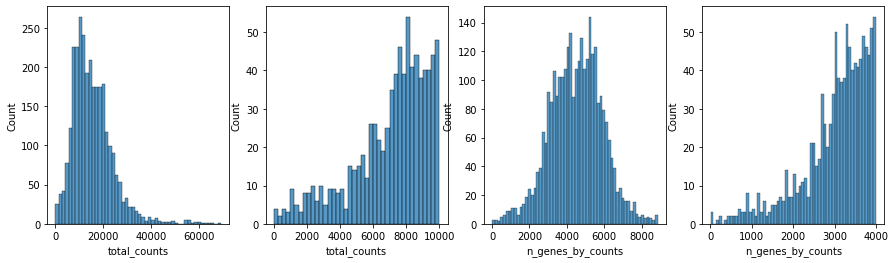

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

Based on the histograms we filter out spots with low read counts or low number of detected genes. We also filter out spots with a high proportion of mitochondrial reads and we remove genes that were detected in less than 10 spots.

In [8]:
sc.pp.filter_cells(adata, min_counts=4500)
sc.pp.filter_cells(adata, min_genes=1500)
sc.pp.filter_genes(adata, min_cells=10)

To properly visualize counts, it is advisable to first normalize the read count in each spot by the total number of reads in this spot, followed by a log transform. However, we do not want to lose the original count data (we will need them later). Fortunately, AnnData has a concept of layers. This means that you can store multiple data matrices for a data set, so we save a copy of our original count matrix to a layer and proceed with normalization.

In [9]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Visualizing spatial data
We can now plot the total number of reads per spot. Scanpy's `spatial` plotting function will put the H&E stained tissue image underneath the spots. The `log1p_total_counts` statistic was calculated by `sc.pp.calculate_qc_metrics` above.

... storing 'feature_types' as categorical
... storing 'genome' as categorical


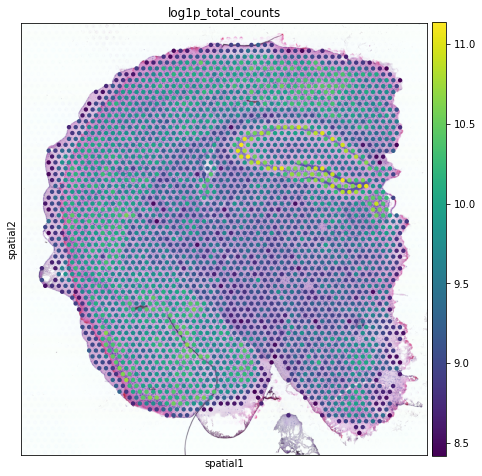

In [10]:
sc.pl.spatial(adata, color="log1p_total_counts")

We can also look at individual genes. For example, let's look at expression of GABA and dopamine receptors. Gabbr1 is the GABA type B receptor subunit 1 and Drd1 is the D(1a) dopamine receptor.

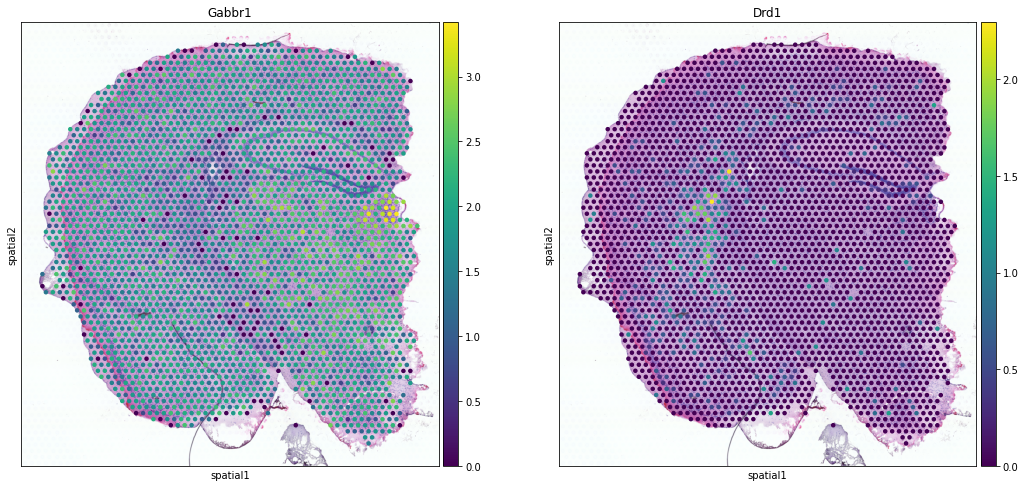

In [11]:
sc.pl.spatial(adata, color=["Gabbr1", "Drd1"])

Suppose we now want to select this cluster of spots with high dopamine receptor expression. Instead of tediously correlating spot indices with coordinates, we can use SquidPy/Napari to interactively select those spots.

In [12]:
image = sq.im.ImageContainer.from_adata(adata, img_key="hires")
viewer = image.interactive(adata)

Traceback (most recent call last):
  File "/data/ilia/practical/lib/python3.7/site-packages/squidpy/pl/_interactive/_widgets.py", line 41, in <lambda>
    self.itemDoubleClicked.connect(lambda item: self._onAction((item.text(),)))
  File "/data/ilia/practical/lib/python3.7/site-packages/squidpy/pl/_interactive/_widgets.py", line 146, in _onAction
    self._controller.add_points(vec, key=item, layer_name=name)
  File "/data/ilia/practical/lib/python3.7/site-packages/squidpy/pl/_interactive/_controller.py", line 187, in add_points
    self._hide_points_controls(layer, is_categorical=is_categorical_dtype(vec))
  File "/data/ilia/practical/lib/python3.7/site-packages/squidpy/pl/_interactive/_controller.py", line 303, in _hide_points_controls
    points_controls = self.view.viewer.window._qt_viewer.controls.widgets[layer]
AttributeError: 'Window' object has no attribute '_qt_viewer'


In the viewer window, first select Drd1 from the gene list by double-clicking. Then add a shape layer and rename it to Dopamine_receptor. Add a polygon selecting Drd1-expressing spots and press Shift+E. This will save a mask of the spots within the polygon to `.obs.Dopamine_receptor_shapes`.

In [13]:
adata.obs

in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAAGTATCTCCCA-1          1         50        102               4678   
AAACACCAATAACTGC-1          1         59         19               3549   
AAACAGAGCGACTCCT-1          1         14         94               6779   
AAACAGCTTTCAGAAG-1          1         43          9               3108   
AAACAGGGTCTATATT-1          1         47         13               4515   
...                       ...        ...        ...                ...   
TTGTTCAGTGTGCTAC-1          1         24         64               8457   
TTGTTGTGTGTCAAGA-1          1         31         77               3464   
TTGTTTCACATCCAGG-1          1         58         42               5457   
TTGTTTCATTAGTCTA-1          1         60         30               5300   
TTGTTTCCATACAACT-1          1         45         27               5143   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAAGTATCTCCCA-1                 8.450840       14284.0            9.566965   
AAACACCAATAACTGC-1                 8.174703        9951.0            9.205529   
AAACAGAGCGACTCCT-1                 8.821732       32155.0           10.378354   
AAACAGCTTTCAGAAG-1                 8.042056        7935.0            8.979165   
AAACAGGGTCTATATT-1                 8.415382       14483.0            9.580800   
...                                     ...           ...                 ...   
TTGTTCAGTGTGCTAC-1                 9.042868       65866.0           11.095393   
TTGTTGTGTGTCAAGA-1                 8.150468        8785.0            9.080914   
TTGTTTCACATCCAGG-1                 8.604838       19956.0            9.901335   
TTGTTTCATTAGTCTA-1                 8.575651       18351.0            9.817493   
TTGTTTCCATACAACT-1                 8.545586       17529.0            9.771669   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACAAGTATCTCCCA-1                   27.457295                    32.812938   
AAACACCAATAACTGC-1                   37.061602                    42.337454   
AAACAGAGCGACTCCT-1                   23.784792                    29.830508   
AAACAGCTTTCAGAAG-1                   32.917454                    39.054820   
AAACAGGGTCTATATT-1                   30.994960                    36.415107   
...                                        ...                          ...   
TTGTTCAGTGTGCTAC-1                   17.673762                    24.381320   
TTGTTGTGTGTCAAGA-1                   27.137166                    33.249858   
TTGTTTCACATCCAGG-1                   23.872520                    29.695330   
TTGTTTCATTAGTCTA-1                   24.892376                    30.477903   
TTGTTTCCATACAACT-1                   25.415027                    31.330937   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACAAGTATCTCCCA-1                    39.897788                    52.856343   
AAACACCAATAACTGC-1                    49.110642                    60.586876   
AAACAGAGCGACTCCT-1                    37.860364                    51.397916   
AAACAGCTTTCAGAAG-1                    46.389414                    59.206049   
AAACAGGGTCTATATT-1                    43.506180                    56.031209   
...                                         ...                          ...   
TTGTTCAGTGTGCTAC-1                    33.152157                    48.190265   
TTGTTGTGTGTCAAGA-1                    41.343199                    55.310188   
TTGTTTCACATCCAGG-1                    37.748046                    51.638605   
TTGTTTCATTAGTCTA-1                    38.194104                    51.670209   
TTGTTTCCATACAACT-1                    39.505962                    53.191853   

                    total_counts_mt  log1p_total_counts_mt  pct_counts_mt  \
AAACAAGTATCTCCCA-1           2847.0               7.954372      19.931393   
AAACACCAATAACTGC-1           2764.0               7.924796      27.776104   
AAACAGAGCGACTCCT-

## clustering spatial data
Suppose we want to create a UMAP plot of our data to check if the dopamine-expressing spots are nicely clustered together. The classical workflow consists of selecting variable genes, followed by PCA, k-nearest-neighbors, and finally UMAP. However, we have additional information available, namely spatial coordinates. So instead of just using highly variable genes, we will use genes that are spatially variable. This means that instead of varying randomly across spots, they follow a smooth pattern of variation across the tissue slice (plus some noise). SpatialDE can detect such spatially variable genes, but on large data sets like this ones you ideally would run this on a GPU to get a decent run time. We therefore have precomputed the spatially variable genes for you. You can download the file [here](ftp://ftp.dkfz-heidelberg.de/outgoing/SCCourse2021/ST8059048_svg_full.pkl).

In [15]:
spatially_variable = pd.read_pickle("data/ST8059048_svg_full.pkl")
spatially_variable

gene      time         kappa         nu       U_tilde  \
0                Xkr4  4.575402    165.971038  17.036499  1.397586e+04   
1               Sox17  0.027742     30.547828  16.417408  5.979530e+02   
2              Mrpl15  0.066843    643.617758  15.840952  1.053182e+04   
3               Tcea1  0.078515    490.561791  15.840952  8.577739e+03   
4               Rgs20  0.015914    250.724726  17.495244  3.661584e+04   
...               ...       ...           ...        ...           ...   
12677         mt-Cytb  0.014791  10150.168478  20.032541  4.055169e+06   
12678           Vamp7  0.072417    359.315564  15.840955  1.463586e+04   
12679           Spry3  0.112053     94.855159  15.840952  2.252656e+03   
12680      AC149090.1  0.017502    519.614113  17.241734  4.828150e+04   
12681  CAAA01118383.1  0.017439    158.913517  16.224905  2.892589e+03   

             e_tilde       I_tilde          pval          padj  total_counts  
0        2827.565490  9.385880e+05  7.014123e-11  2.765955e-10         816.0  
1         501.516158  3.064046e+04  2.630273e-01  3.147789e-01         131.0  
2       10195.517969  1.312403e+07  4.167195e-01  4.654604e-01        2497.0  
3        7770.965741  7.624278e+06  3.444157e-01  3.960359e-01        1903.0  
4        4386.490378  2.199603e+06  0.000000e+00  0.000000e+00        1400.0  
...              ...           ...           ...           ...           ...  
12677  203333.663036  4.127742e+09  0.000000e+00  0.000000e+00      587548.0  
12678    5691.901540  4.090378e+06  5.584431e-04  1.191483e-03        1394.0  
12679    1502.596012  2.850580e+05  9.069494e-02  1.249531e-01         368.0  
12680    8959.048492  9.310496e+06  2.221223e-12  9.516741e-12        2785.0  
12681    2578.356708  8.194715e+05  3.262924e-01  3.783178e-01         663.0  

[12682 rows x 10 columns]

We select 2000 most highly expressed spatially variable genes and use those for the PCA.

In [16]:
vargenes = spatially_variable[spatially_variable.padj < 0.001].sort_values("total_counts", ascending=False).gene[:2000]

Before performing PCA we still need to remove the influence of total number of reads per spot on the expression. Although we have already normalized the data using `sc.pp.normalize_total`, which divides counts for each gene by the total number of reads in a spot, this very simple normalization is often not sufficient to remove all artifacts associated with different total read counts. `sc.pp.regress_out` performs a linear regression for each gene using the total read counts per spot as a predictor, and uses the residuals from that regression as new expression values.

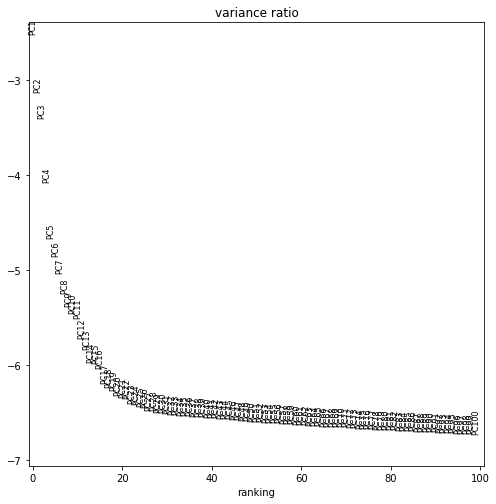

In [17]:
adata_variable = adata[:, vargenes]
sc.pp.regress_out(adata_variable, ['total_counts'])
sc.pp.pca(adata_variable, n_comps=100)
sc.pl.pca_variance_ratio(adata_variable, log=True, n_pcs=100)

We create a k-nearest-neighbors in the PCA space and use it to create a UMAP, which will be colored by whether a spot belongs to our set of spots with high dopamine receptor expression.

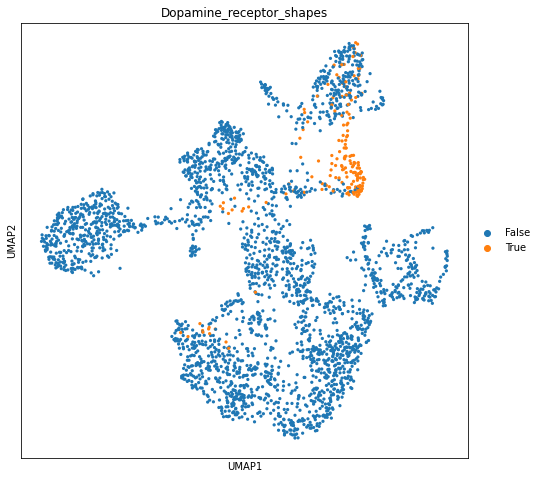

In [18]:
sc.pp.neighbors(adata_variable, n_neighbors=20, n_pcs=80)
sc.tl.umap(adata_variable)
sc.pl.umap(adata_variable, color="Dopamine_receptor_shapes")

So the dopamine expressing cells are located close together in gene expression space, which suggests that this is a brain region that responds to dopamine. Suppose we now want segment our entire data set into distinct regions. We could of course do what we just did: manually look through lots of genes and manually select the corresponding regions. However, that approach is tedious, irreproducible, and can potentiall overlook things. The development version of SpatialDE implements a segmentation method that groups spots by their expression, but encourages the clusters to be spatially smooth, i.e. neighboring spots should belong to the same cluster. This method is probabilistically motivated and works on raw counts, so we let it loose on the `counts` layer that we created previously.

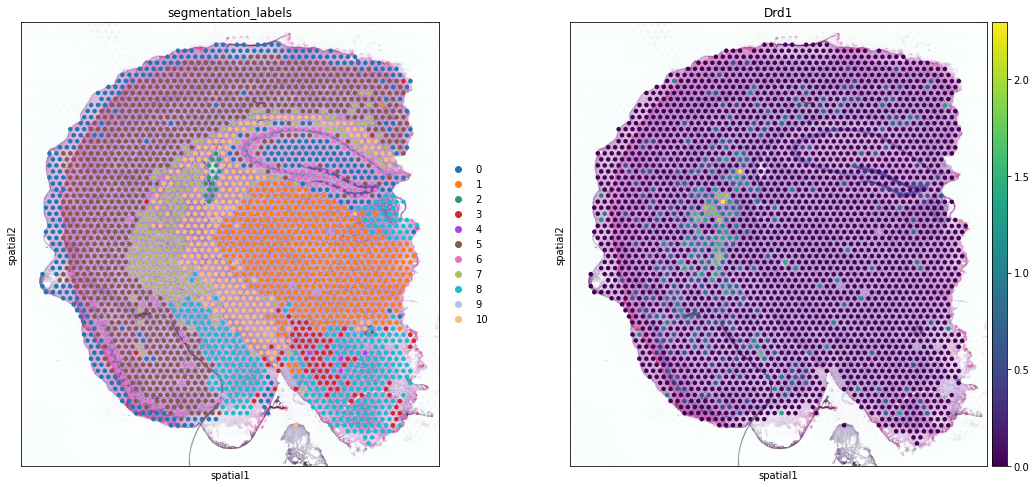

In [19]:
segmentation, _ = SpatialDE.tissue_segmentation(adata, genes=vargenes, layer="counts", rng=np.random.default_rng(seed=42))
sc.pl.spatial(adata, color=["segmentation_labels", "Drd1"])

As we can see, our dopamine-receptor-expressing spots are all clustered into the same cluster, but we also uncover distinct clusters in other brain regions. We can compare SpatialDE's results to a standard Leiden clustering, run on the k-nearest-neighbors graph we created previously.

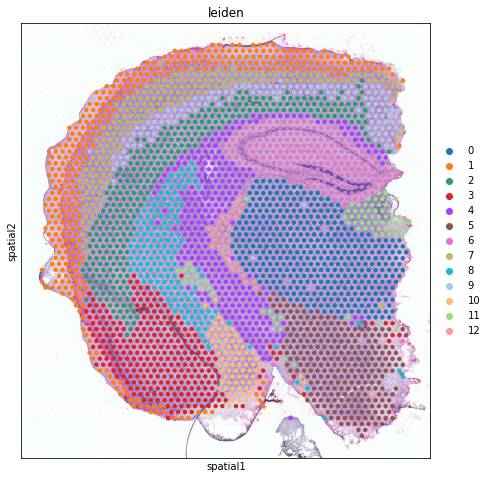

In [20]:
sc.tl.leiden(adata_variable, random_state=42)
sc.pl.spatial(adata_variable, color=["leiden"])

Leiden seems to resolve some areas better than SpatialDE, e.g. the layered structure of the isocortex, but some worse, e.g. the hippocampus. We can look at UMAPs colored by the two segmentations:

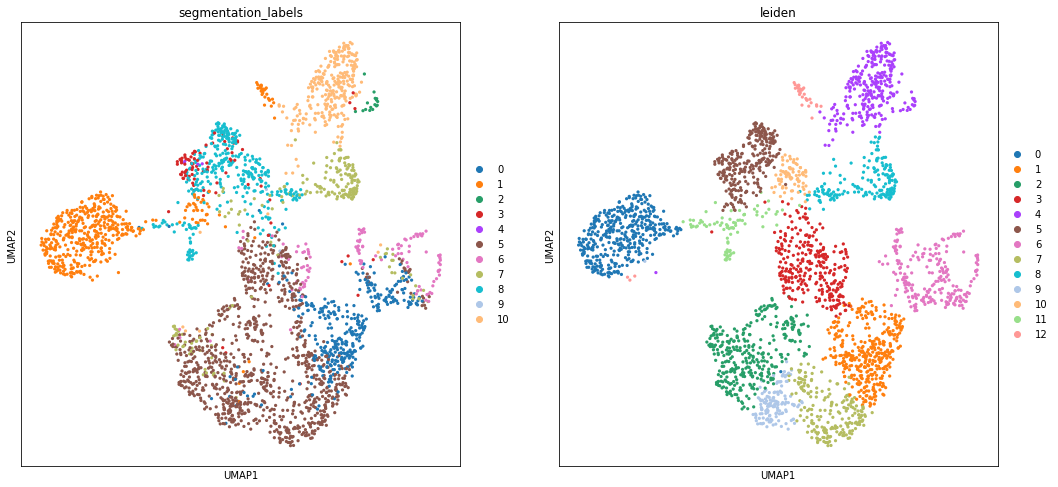

In [21]:
adata_variable.obs["segmentation_labels"] = adata.obs.segmentation_labels
sc.pl.umap(adata_variable, color=["segmentation_labels", "leiden"])

As expected, Leiden clusters correspond solely to distance in gene expression space. The hippocampus in particular looks like one cluster in gene expression space, possibly because the number of spots covering pyramidal neurons is so low.

We can increase SpatialDE's resolution by tweaking the spatial smoothness penalty. With reduced penalty (corresponding to a larger `smoothness_factor`), SpatialDE also recovers the layered structure of the isocortex, plus some additional details.

In [22]:
segmentation, _ = SpatialDE.tissue_segmentation(adata, genes=vargenes, layer="counts", rng=np.random.default_rng(seed=42), params=SpatialDE.TissueSegmentationParameters(smoothness_factor=5))

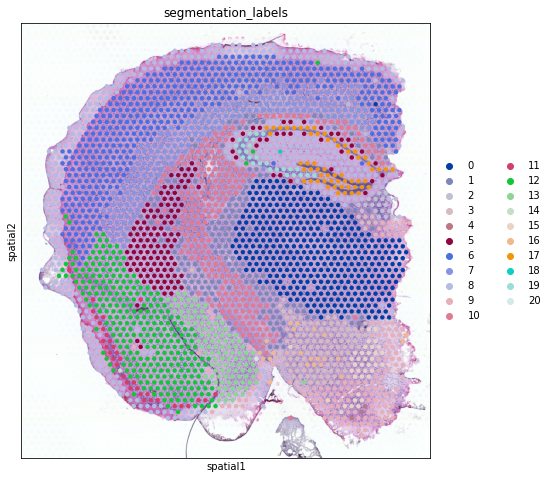

In [23]:
sc.pl.spatial(adata, color="segmentation_labels")

## deconvolving cell types with cell2location
10x Visium is not a single-cell technology, each spot contains approx. 10-50 cells, which can belong to different cell types. Deconvolution methods use a single-cell reference data set to model each spot as a mixture of cell types. We will use [cell2location](https://doi.org/10.1038/s41587-021-01139-4) to illustrate deconvolution of the mouse brain data set. The single-cell reference can be downloaded [here](https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/all_cells_20200625.h5ad) and the cell type assignment [here](https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/snRNA_annotation_astro_subtypes_refined59_20200823.csv).

First, we read the reference, merge the cell type information, and remove low-quality genes. In particular, we remove all genes that are expressed in less than 50 cells, and genes that are expressed in more than 50 cells but less than 5% of the total number of cells are included only if their average expression is above 1.15.

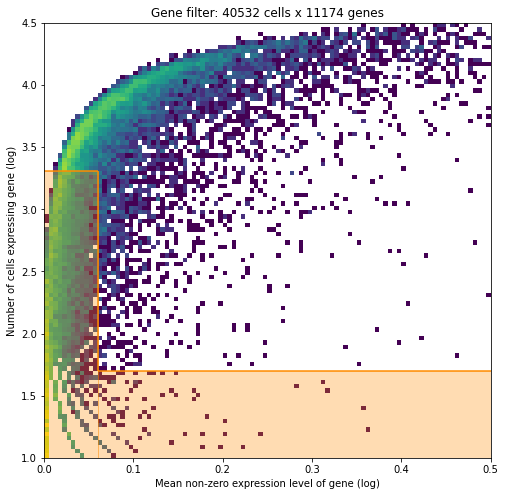

In [24]:
adata_ref = ad.read_h5ad("data/all_cells_20200625.h5ad")
celltypes = pd.read_csv("data/snRNA_annotation_astro_subtypes_refined59_20200823.csv", index_col=0).rename({"annotation_1": "celltype"}, axis=1)
celltypes.celltype = pd.Categorical(celltypes.celltype)
adata_ref = adata_ref[celltypes.index, :]
adata_ref.obs = pd.concat([adata_ref.obs, celltypes], axis=1, join="inner")
selected = filter_genes(adata_ref, cell_count_cutoff=50, cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.15)
adata_ref = adata_ref[:, selected].copy()

We now estimate the reference expression signatures. The model used by cell2location takes batch and technical effects into account, which is important as our reference was built from 6 separate samples. This takes quite some time, so we already trained the model.

In [25]:
RegressionModel.setup_anndata(adata=adata_ref,
                        batch_key='sample',
                        labels_key='celltype'
                       )
mod = RegressionModel(adata_ref)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 40532 │
│          n_vars          │ 11174 │
│         n_batch          │   6   │
│         n_labels         │  59   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ 5705STDY8058280 │          0          │
│                     │ 5705STDY8058281 │          1          │
│                     │ 5705STDY8058282 │          2          │
│                     │ 5705STDY8058283 │          3          │
│                     │ 5705STDY8058284 │          4          │
│                     │ 5705STDY8058285 │          5          │
└─────────────────────┴─────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │   Astro_AMY    │          0          │
│                       │ Astro_AMY_CTX  │          1          │
│                       │   Astro_CTX    │          2          │
│                       │   Astro_HPC    │          3          │
│                       │   Astro_HYPO   │          4          │
│                       │   Astro_STR    │          5          │
│                       │ Astro_THAL_hab │          6          │
│                       │ Astro_THAL_lat │          7          │
│                       │ Astro_THAL_med │          8          │
│                       │    Astro_WM    │          9          │
│                       │      Endo      │         10          │
│                       │   Ext_Amy_1    │         11          │
│                       │   Ext_Amy_2    │         12          │
│                       │  Ext_ClauPyr   │         13          │
│                       │  Ext_Hpc_CA1   │         14          │
│                       │  Ext_Hpc_CA2   │         15          │
│                       │  Ext_Hpc_CA3   │         16          │
│                       │  Ext_Hpc_DG1   │         17          │
│                       │  Ext_Hpc_DG2   │         18          │
│                       │    Ext_L23     │         19          │
│                       │    Ext_L25     │         20          │
│                       │    Ext_L56     │         21          │
│                       │    Ext_L5_1    │         22          │
│                       │    Ext_L5_2    │         23          │
│                       │    Ext_L5_3    │         24          │
│                       │     Ext_L6     │         25          │
│                       │    Ext_L6B     │         26          │
│                       │    Ext_Med     │         27          │
│                       │    Ext_Pir     │         28          │
│                       │   Ext_Thal_1   │         29          │
│                       │   Ext_Thal_2   │         30          │
│                       │   Ext_Unk_1    │         31          │
│                       │   Ext_Unk_2    │         32          │
│                       │   Ext_Unk_3    │         33          │
│                       │     Inh_1      │         34          │
│                       │     Inh_2      │         35          │
│                       │     Inh_3      │         36          │
│                       │     Inh_4      │         37          │
│                       │     Inh_5      │         38          │
│                       │     Inh_6      │         39          │
│                       │   Inh_Lamp5    │         40          │
│                       │  Inh_Meis2_1   │         41          │
│                       │  Inh_Meis2_2   │         42          │
│                       │  Inh_Meis2_3   │         43          │
│                       │  Inh_Meis2_4   │         44          │
│                       │   Inh_Pvalb    │         45          │
│                       │    Inh_Sst     │         46          │
│                       │    Inh_Vip     │         47          │
│                       │     LowQ_1     │         48          │
│                       │     LowQ_2     │         49          │
│                       │     Micro      │         50          │
│                       │      Nb_1      │         51          │
│                       │      Nb_2      │         52          │
│                       │     OPC_1      │         53          │
│                       │     OPC_2      │         54          │
│                       │    Oligo_1     │         55          │
│                       │    Oligo_2     │         56          │
│                       │     Unk_1

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/ilia/practical/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|                                                                                                                                                                | 0/500 [00:00<?, ?it/s]

/data/ilia/practical/lib/python3.7/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/kats/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [30:03<00:00,  3.61s/it, v_num=1, elbo_train=2.44e+8]


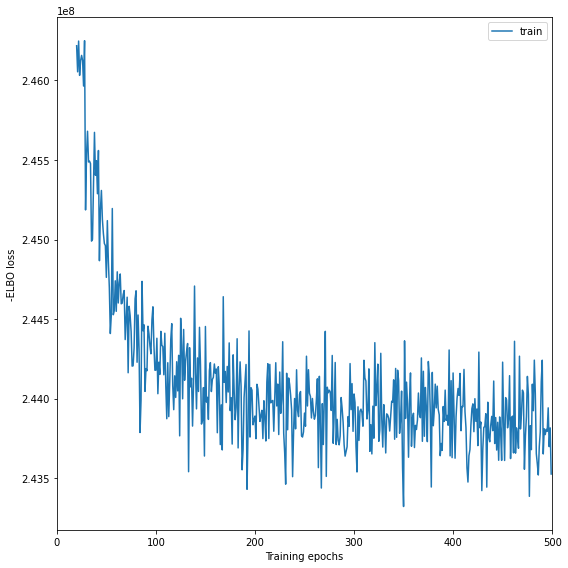

In [17]:
mod = RegressionModel(adata_ref)
mod.train(max_epochs=500, batch_size=2500, train_size=1, lr=0.001, use_gpu=True)
mod.plot_history(20)

In [18]:
mod.save("data/reference_signatures", overwrite=True)

In [26]:
mod = RegressionModel.load("data/reference_signatures", adata_ref)

INFO     File data/reference_signatures/model.pt already downloaded                          
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/ilia/practical/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/493:   0%|                                                                                                                                                                     | 0/493 [00:00<?, ?it/s]

/data/ilia/practical/lib/python3.7/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/kats/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)


Epoch 1/493:   0%|▎                                                                                                                               | 1/493 [00:01<09:39,  1.18s/it, v_num=1, elbo_train=2.49e+8]


We can now use the trained model to estimate gene expression signatures for our cell types and assess predictive performance of the trained model. Parameter estimation requires sampling from the posterior distribution of the model, so it takes some time and a lot of memory. We therefore provde precomputed results.

In [20]:
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 10000, 'batch_size': 2500, 'use_gpu': True}
)
adata_ref.write("data/all_cells_20200625_c2l.h5ad", compression="gzip", compression_opts=9)

Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [03:49<00:00, 43.55it/s]


We can now do some quality control of our model. The first plot compares posterior estimates of gene expression ($\mu_{c,g}$ in the cell2location paper) to actual gene expression. The second plot compares the estimated cell type signatures ($g_{f,g}$ in the cell2location paper) to a simple average of all cells of cell type $f$.

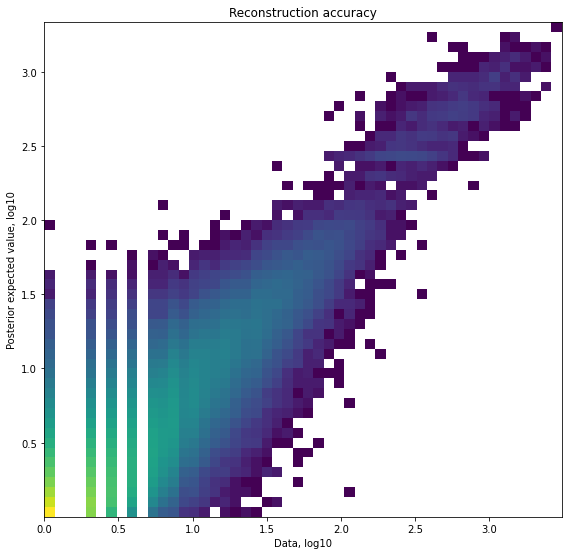

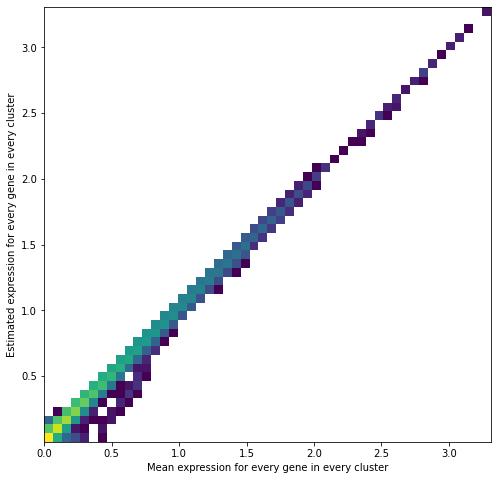

In [21]:
mod.plot_QC()

In [27]:
adata_ref = ad.read_h5ad("data/all_cells_20200625_c2l.h5ad")

We now have to subset our reference and spatial data sets to contain only genes that were detected in both. Then we can configure and train our cell2location model.

In [28]:
inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]]
inf_aver.columns = adata_ref.uns['mod']['factor_names']
                                 
intersect = adata_ref.var_names.intersection(adata.var.gene_ids)

adata_vis = adata[:, adata.var.gene_ids.isin(intersect)].copy()
inf_aver = inf_aver.loc[intersect, :]
adata_vis.var = adata_vis.var.reset_index().rename(columns={"index": "gene_name"}).set_index("gene_ids")
Cell2location.setup_anndata(adata_vis, layer="counts")
mod = Cell2location(
                    adata_vis,
                    cell_state_df=inf_aver,
                    N_cells_per_location=30)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 2871  │
│          n_vars          │ 10613 │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [26]:
mod.train(max_epochs=30000,
          batch_size=None,
          train_size=1,
          use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/ilia/practical/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/data/ilia/practical/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30000/30000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [54:00<00:00,  9.26it/s, v_num=1, elbo_train=2.83e+7]


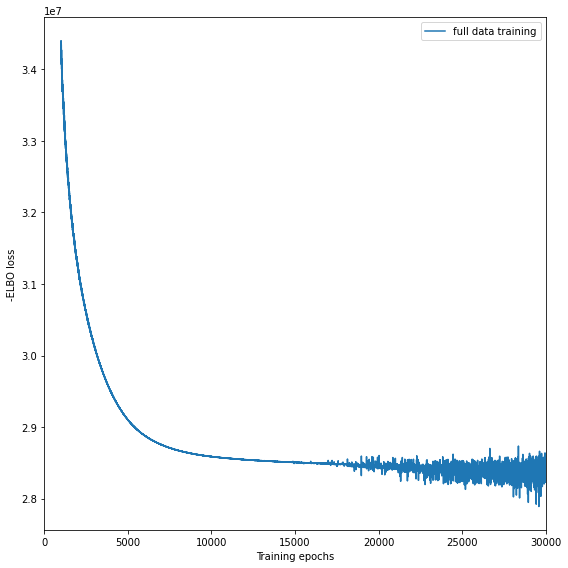

In [27]:
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 10000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)
mod.save("data/cell2location_model", overwrite=True)
adata_vis.write("data/mouse_brain.h5ad", compression="gzip", compression_opts=9)

Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [03:09<00:00, 52.64it/s]


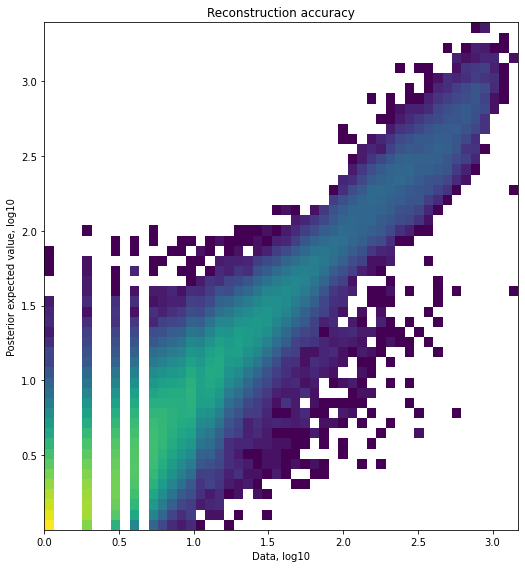

In [29]:
mod.plot_QC()

In [29]:
adata_vis = ad.read_h5ad("data/mouse_brain.h5ad")
mod = cell2location.models.Cell2location.load("data/cell2location_model", adata_vis)

INFO     File data/cell2location_model/model.pt already downloaded                           
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/ilia/practical/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/data/ilia/practical/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1/30000:   0%|                                                                                                                            | 1/30000 [00:00<59:45,  8.37it/s, v_num=1, elbo_train=8.41e+7]


Now we can plot the spatial distribution of cell types of interest

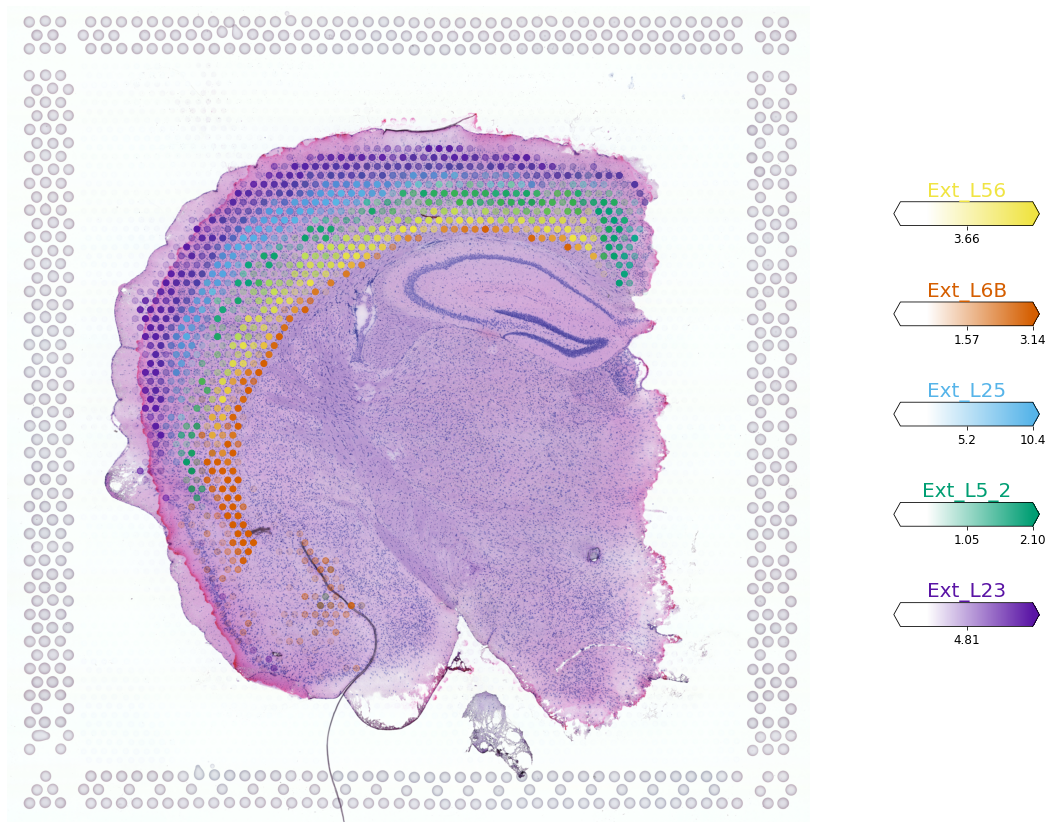

In [30]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
with mpl.rc_context({'figure.figsize': (20, 15)}):
    plot_spatial(adata_vis,
                 color=["Ext_L56", "Ext_L6B", "Ext_L25", "Ext_L5_2", "Ext_L23"],
                 labels=["Ext_L56", "Ext_L6B", "Ext_L25", "Ext_L5_2", "Ext_L23"],
                 circle_diameter=6,
                 colorbar_position='right')

## extracting image features
Sometimes, one would like to include features features from the corresponding tissue images in one's analysis. SquidPy contains several functions that can extract classical computer vision features from an image, but we will use a different approach here. We will use a neural network, pre-trained to classify the ImageNet data set, without its top classification layer. The neuron activations of the second-to-last layer (i.e. the layer immediately preceding the classification layer) will be our features.

In [34]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

inputs = tf.keras.layers.Input(shape=next(iter(image.generate_spot_crops(adata,as_array="hires", spot_scale=1.5))).shape)
resnet = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_tensor=inputs, pooling="avg")
resnet.compile()

SquidPy provides a handy function to generate image crops surrounding each spot.

In [36]:
topredict = np.stack(tuple(image.generate_spot_crops(adata, as_array="hires", spot_scale=1.5)), axis=0)
features = resnet(topredict).numpy()

In [37]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [38]:
features.shape

(2871, 2048)

In [39]:
np.sum(features > 0)

93616

In [40]:
features[features > 0]

array([1.9342294 , 0.00362313, 0.1191293 , ..., 0.24244487, 0.37149858,
       0.15990484], dtype=float32)

In [41]:
features = sparse.csr_matrix(features)

## working with multimodal data
We could force the features matrix into our original AnnData object, e.g. by using the `obsm` slot, but that wouldn't really be useful. Instead, we can create a second AnnData object holding the image features, and group the two AnnData objects together. For this, we will use [muon](https://muon.readthedocs.io), a new package to make working with multi-modal data sets easier.

In [42]:
features = ad.AnnData(X=features, obs=pd.DataFrame(index=adata.obs_names))
mu.set_options(display_style="html")

In [43]:
multim = mu.MuData({"visium": adata, "resnet_features": features})

In [44]:
multim

MuData object with n_obs × n_vars = 2871 × 19114
  2 modalities
    visium:	2871 x 17066
      obs:	'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'Dopamine_receptor_shapes', 'segmentation_labels'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'spatial', 'log1p', 'segmentation_labels_colors'
      obsm:	'spatial', 'segmentation_class_probabilities'
      layers:	'counts'
    resnet_features:	2871 x 2048

## finding smooth spatial factors with MEFISTO
MEFISTO is an extension of MOFA that imposes a spatial smoothness constraint on the factors. It is implemented using Gaussian processes. Here we will use MEFISTO to identify smooth factors in the mouse brain tissue.

We first create a MOFA object and set all the required options.

In [45]:
from mofapy2.run.entry_point import entry_point
ent = entry_point()
ent.set_data_options(use_float32=True)
ent.set_data_from_anndata(adata_variable)
ent.set_model_options(factors=4)
ent.set_train_options(seed=42)
ent.set_covariates([adata.obsm["spatial"]], covariates_names=["x", "y"])
ent.set_smooth_options(sparseGP=True, frac_inducing=0.3, start_opt=10, opt_freq=10)
ent.build()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
use_float32 set to True: replacing float64 arrays by float32 arrays to speed up computations...

Loaded view='rna' group='group1' with N=2871 samples and D=2000 features...


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab pr

We the train the model and save the results. Training takes quite some time, so we provide a pre-trained model.

In [34]:
ent.run()
ent.save("data/ST8059048_MEFISTO.h5")



######################################
## Training the model with seed 42 ##
######################################


ELBO before training: -22257797.92 

Iteration 1: time=1.55, ELBO=-4548065.20, deltaELBO=17709732.719 (79.56641886%), Factors=4
Iteration 2: time=1.55, ELBO=-4341672.34, deltaELBO=206392.853 (0.92728335%), Factors=4
Iteration 3: time=1.54, ELBO=-4328451.67, deltaELBO=13220.673 (0.05939794%), Factors=4
Iteration 4: time=1.55, ELBO=-4322963.51, deltaELBO=5488.163 (0.02465726%), Factors=4
Iteration 5: time=1.56, ELBO=-4319266.40, deltaELBO=3697.106 (0.01661038%), Factors=4
Iteration 6: time=1.54, ELBO=-4317211.94, deltaELBO=2054.460 (0.00923029%), Factors=4
Iteration 7: time=1.60, ELBO=-4316324.08, deltaELBO=887.858 (0.00398898%), Factors=4
Iteration 8: time=1.56, ELBO=-4315898.55, deltaELBO=425.540 (0.00191187%), Factors=4
Iteration 9: time=1.60, ELBO=-4315597.85, deltaELBO=300.698 (0.00135098%), Factors=4
Optimising sigma node...
Iteration 10: time=434.79, ELBO=-425883

We use the mofax package to access the trained model. We first load the model and plot the correlation between factors. Ideally, it should be 0.

<AxesSubplot:>

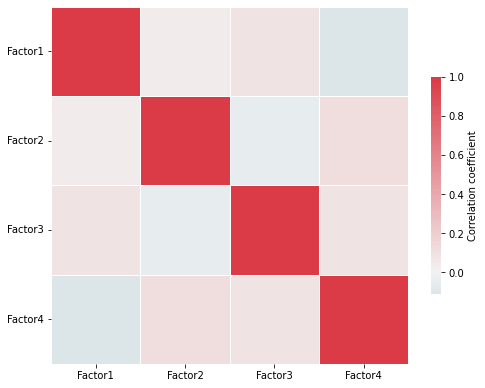

In [46]:
m = mofax.mofa_model("data/ST8059048_MEFISTO.h5")
mofax.plot_factors_correlation(m)

We can also plot the individual factors:

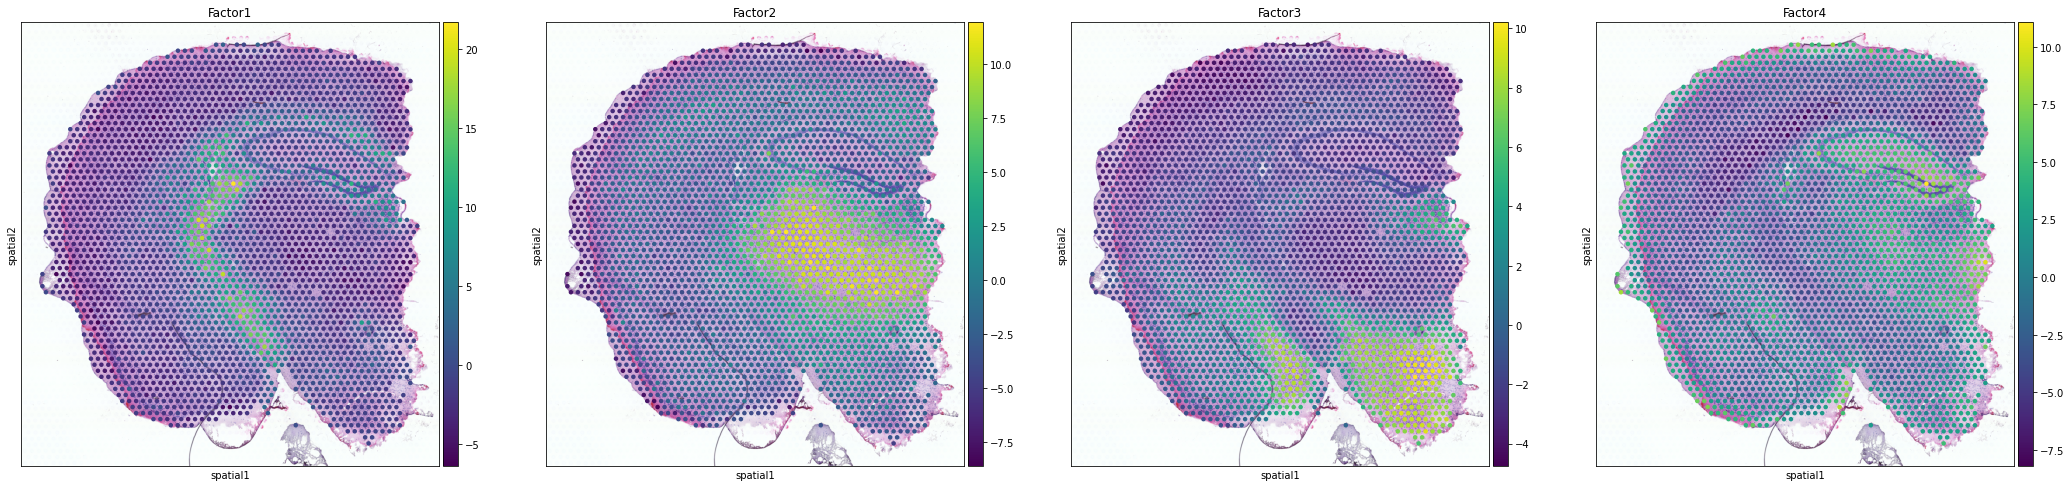

In [47]:
adata.obs = adata.obs.join(m.get_factors(df=True))
sc.pl.spatial(adata, color=[f"Factor{i+1}" for i in range(4)])

We can also look at the fraction of variance attributed to structured spatial variation vs. random nose for each factor:

<AxesSubplot:xlabel='Smoothness', ylabel='Factor'>

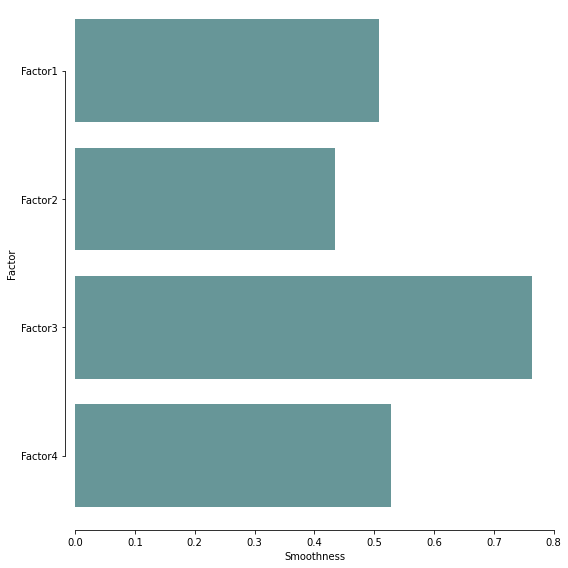

In [48]:
mofax.plot_smoothness(m)

Finally, we can get genes with the highest weights for factor 2 and look at their expression.

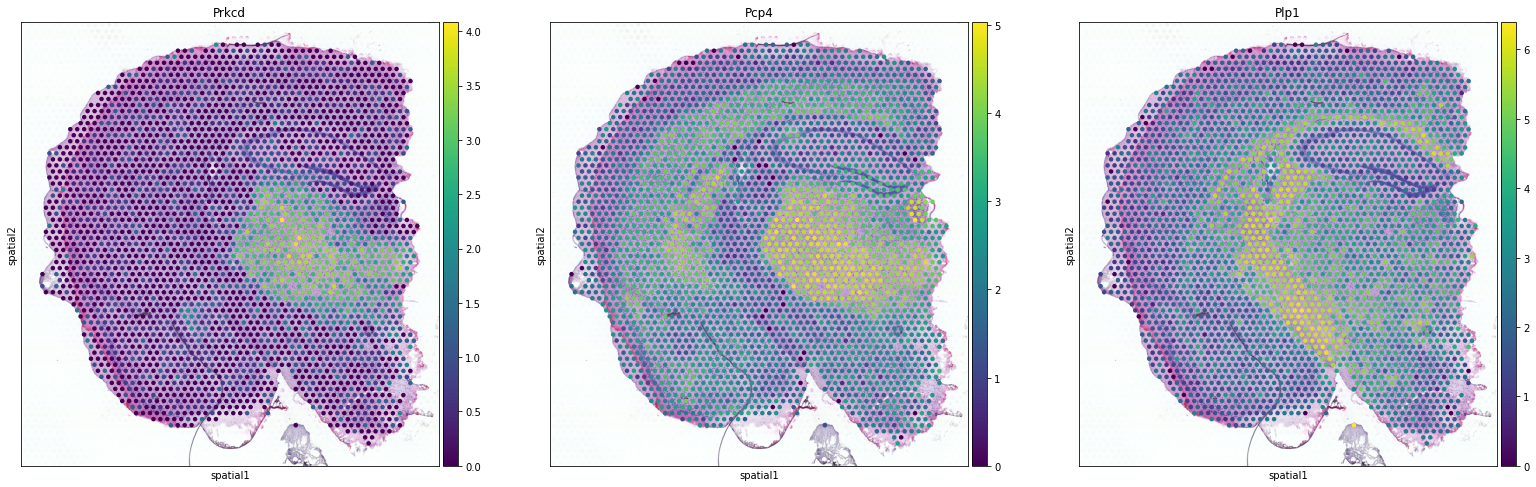

In [49]:
top_features_f2 = m.get_top_features(factors="Factor2", n_features=3)
sc.pl.spatial(adata, color=top_features_f2)

# exercises
## variable genes
Compare the spatially variable genes by SpatialDE with the highly variable genes generated by Scanpy.

## clustering
### cluster by cell type composition
Cell2location also computes a posterior estimate of the UMI count per cell type for each spot. Try to figure out where this is stored in the AnnData object and apply SpatialDE and Leiden clustering to it. Compare with clustering in gene expression space.

### Image features
Perform Leiden clustering on the image features and compare it to the clustering in gene expression space.

### Joint clustering of gene expression and image features
Muon provides a multimodal version of the Leiden clustering algorithm. See if you can get better results by including image features in the clustering. You should also try to use Muon's weighted nearest neighbors implementation to generate UMAPs based on both gene expression and image features. Also experiment with SquidPy's other image features and compare the clusterings.

## smooth factorization
MEFISTO can also work with multiple data types (called views). Muon provides a convenient interface for this functionality. Fit a MEFISTO model to both RNA and image features and compare the factors.

# additional resources
## tutorials
- [Best practices for single-cell analysis (non-spatial)](https://www.embopress.org/doi/full/10.15252/msb.20188746)
- [Scanpy tutorials](https://scanpy-tutorials.readthedocs.io/en/latest/)
- [muon tutorials](https://muon-tutorials.readthedocs.io/en/latest/)
- [MEFISTO tutorials](https://github.com/bioFAM/MEFISTO_tutorials)
- [Squidpy tutorials](https://squidpy.readthedocs.io/en/latest/tutorials.html)

## reference documentation
- [Scanpy](https://scanpy.readthedocs.io/en/stable/)
- [muon](https://muon.readthedocs.io/en/latest/)
- [Squidpy](https://squidpy.readthedocs.io/en/latest/)